### 1) Loading dataset

* importing necessary libraries to read dataset

In [1]:
import os
import ast
import numpy as np
import pandas as pd
from PIL import Image

* setting paths for dataset files

In [2]:
# setting paths for train and test data
train_dir = "train"
train_annot_path = os.path.join(train_dir, "annotation.txt")

test_dir = "test"
test_annot_path = os.path.join(test_dir, "annotation.txt")

# setting paths for classes.txt
classes_txt_path = "classes.txt"

* getting class labels from annotation and class files

In [3]:
# getting class labels from "classes.txt"
with open(classes_txt_path) as file:
    class_map_s2i = {line.rstrip():i for i, line in enumerate(file.readlines()) if line.rstrip()}
class_map_i2s = {v:k for k,v in class_map_s2i.items()}

# getting labels for train data from "train/annotation.txt"
with open(train_annot_path) as file:
    train_annots = [line.rstrip().split() for line in file.readlines()]
train_img_path = [os.path.join(train_dir, "0"+train_annot[0][:3], train_annot[0]+".jpg") for train_annot in train_annots]
train_int_lbl = [np.argmax(np.array([int(ast.literal_eval(x)) for x in train_annot[1:]])) for train_annot in train_annots]
train_str_lbl = [class_map_i2s[x] for x in train_int_lbl]

# getting labels for test data from "test/annotation.txt"
with open(test_annot_path) as file:
    test_annots = [line.rstrip().split() for line in file.readlines()]
test_img_path = [os.path.join(test_dir, "0"+test_annot[0][:3], test_annot[0]+".jpg") for test_annot in test_annots]
test_int_lbl = [np.argmax(np.array([int(ast.literal_eval(x)) for x in test_annot[1:]])) for test_annot in test_annots]
test_str_lbl = [class_map_i2s[x] for x in test_int_lbl]

* creating dataframes for train and test set

In [4]:
# creating dataframes for train and test data
train_df = pd.DataFrame({"img_path":train_img_path, "int_label":train_int_lbl, "str_label":train_str_lbl})
test_df = pd.DataFrame({"img_path":test_img_path, "int_label":test_int_lbl, "str_label":test_str_lbl})

# displaying dataframes
print("\n\nTRAIN DF")
display(train_df)
print(train_df.str_label.value_counts(dropna=False))

print("\n\n\nTEST DF")
display(test_df)
print(test_df.str_label.value_counts())



TRAIN DF


,img_path,int_label,str_label
0,train\0000\000000.jpg,4,tree
1,train\0000\000001.jpg,1,car
2,train\0000\000002.jpg,2,building
3,train\0000\000003.jpg,1,car
4,train\0000\000004.jpg,1,car
...,...,...,...
39995,train\0039\039995.jpg,0,person
39996,train\0039\039996.jpg,0,person
39997,train\0039\039997.jpg,0,person
39998,train\0039\039998.jpg,0,person


str_label
person       24024
window        4153
car           3994
building      2233
tree          2073
sign           968
door           881
chair          432
bookshelf      404
keyboard       350
head           268
table          220
Name: count, dtype: int64



TEST DF


,img_path,int_label,str_label
0,test\0000\000000.jpg,1,car
1,test\0000\000001.jpg,0,person
2,test\0000\000002.jpg,1,car
3,test\0000\000003.jpg,1,car
4,test\0000\000004.jpg,0,person
...,...,...,...
9995,test\0009\009995.jpg,0,person
9996,test\0009\009996.jpg,1,car
9997,test\0009\009997.jpg,2,building
9998,test\0009\009998.jpg,0,person


str_label
person       5937
window       1043
car          1019
building      588
tree          543
sign          258
door          191
chair         107
bookshelf     103
keyboard       84
head           65
table          62
Name: count, dtype: int64


* visualizing the images in the dataset

Image Class: tree
Image Height: 256
Image Width: 256


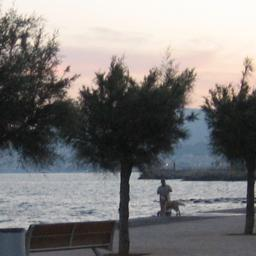

In [5]:
# displaying first image from train data
print(f"Image Class: {train_df.str_label[0]}")
print(f"Image Height: {Image.open(train_df.img_path[0]).height}")
print(f"Image Width: {Image.open(train_df.img_path[0]).width}")
Image.open(train_df.img_path[0])

Image Class: car
Image Height: 256
Image Width: 256


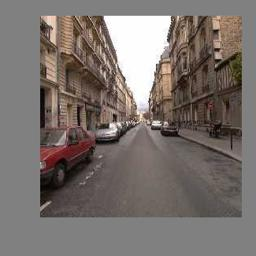

In [6]:
# displaying last image from train data
print(f"Image Class: {train_df.str_label[len(train_df)-1]}")
print(f"Image Height: {Image.open(train_df.img_path[len(train_df)-1]).height}")
print(f"Image Width: {Image.open(train_df.img_path[len(train_df)-1]).width}")
Image.open(train_df.img_path[len(train_df)-1])

Image Class: car
Image Height: 256
Image Width: 256


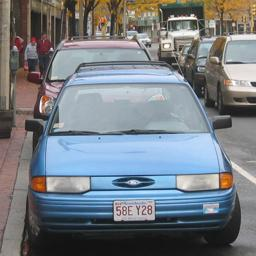

In [7]:
# displaying first image from test data
print(f"Image Class: {test_df.str_label[0]}")
print(f"Image Height: {Image.open(test_df.img_path[0]).height}")
print(f"Image Width: {Image.open(test_df.img_path[0]).width}")
Image.open(test_df.img_path[0])

<Axes: xlabel='str_label'>

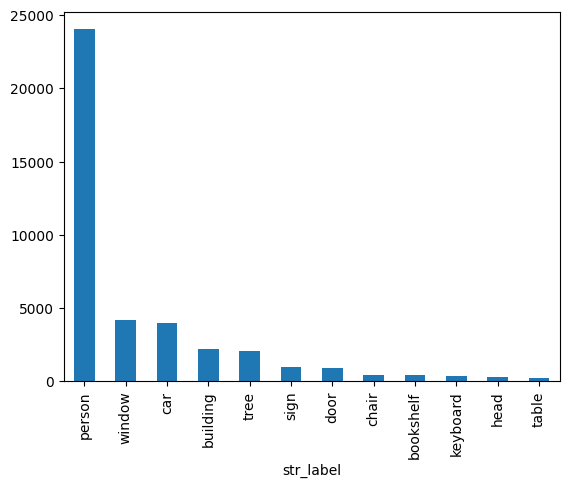

In [8]:
# plotting class distribution for train data
train_df['str_label'].value_counts().plot(kind='bar')

### 2) Creating Dataloaders

* importing necessary libraries for dataloader

In [9]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary

* defining class to load custom dataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        img = Image.open(img_path)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            img = self.transform(img)

        return img, label


* defining transforms

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])  # Normalized using ImageNet stats
])


* instantiating custom dataset for train and test data

In [12]:
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

* creating dataloaders for train and test data

In [13]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
# Find the number of samples/batches per dataloader
print(f"Number of batches of size {batch_size} in training data: {len(train_loader)}")
print(f"Number of batches of size {batch_size} in testing data: {len(test_loader)}")
print(f"Number of classes: {len(class_map_s2i)}, class names: {class_map_s2i}")

Number of batches of size 32 in training data: 1250
Number of batches of size 32 in testing data: 313
Number of classes: 12, class names: {'person': 0, 'car': 1, 'building': 2, 'window': 3, 'tree': 4, 'sign': 5, 'door': 6, 'bookshelf': 7, 'chair': 8, 'table': 9, 'keyboard': 10, 'head': 11}


### 3) Setting up device agnostic code

In [15]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 4) Defining Model

In [16]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [17]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [20]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
class_names = class_map_s2i.keys()
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [21]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 12]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [22]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import engine

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7652 | train_acc: 0.7662 | test_loss: 0.6485 | test_acc: 0.7924
Epoch: 2 | train_loss: 0.6143 | train_acc: 0.8006 | test_loss: 0.6042 | test_acc: 0.8062
Epoch: 3 | train_loss: 0.5792 | train_acc: 0.8084 | test_loss: 0.5933 | test_acc: 0.8042
Epoch: 4 | train_loss: 0.5614 | train_acc: 0.8138 | test_loss: 0.5599 | test_acc: 0.8144
Epoch: 5 | train_loss: 0.5460 | train_acc: 0.8177 | test_loss: 0.5503 | test_acc: 0.8180
Epoch: 6 | train_loss: 0.5351 | train_acc: 0.8189 | test_loss: 0.5565 | test_acc: 0.8124
Epoch: 7 | train_loss: 0.5309 | train_acc: 0.8206 | test_loss: 0.5458 | test_acc: 0.8177
Epoch: 8 | train_loss: 0.5232 | train_acc: 0.8225 | test_loss: 0.5396 | test_acc: 0.8209
Epoch: 9 | train_loss: 0.5208 | train_acc: 0.8225 | test_loss: 0.5401 | test_acc: 0.8209
Epoch: 10 | train_loss: 0.5239 | train_acc: 0.8210 | test_loss: 0.5409 | test_acc: 0.8205
[INFO] Total training time: 1174.199 seconds


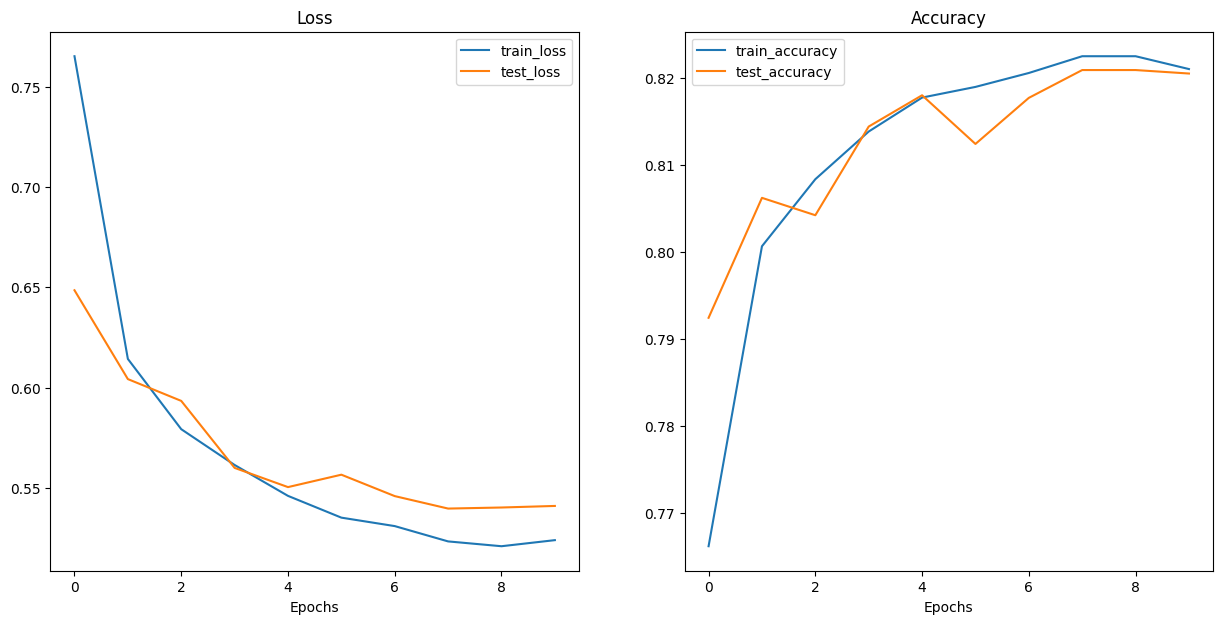

In [24]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)